In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import matplotlib
plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.titlesize'] = 9
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['ytick.minor.size'] = 1.5
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.minor.width'] = 0.4
plt.rcParams['figure.dpi'] = 225
plt.rcParams['figure.figsize'] = [7.5/2.54, 5/2.54]
plt.rcParams['path.simplify'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['legend.frameon'] = False
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.formatter.limits'] = (-3,3)


/home/jwl2182/.conda/envs/a40/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.


In [3]:
def paton_function(x):
    a, b, c, d = [-3.5, 11.5, 0.9, 1]
    return 0.5*(a + (b / (1+c*np.exp(1-d*x))))

In [4]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

num_trials = 100
timesteps = 200
num_states = 2
num_actions = 2
default_actions = 0
num_neurons = 2

beta = 10.0
lr = 0.05
lr_V = 0.05
efference_noise = 0.0 * np.sqrt(num_neurons)#was 0.05
explore_noise= 0.0*np.sqrt(num_neurons)
state_noise = 0.0
action_noise = 0.0
reward_types = ["r-V"]
modes = ["linear_raw", "linear_wta", "linear_efference", "rectified_raw", "rectified_wta", "rectified_efference", "paton_raw", "paton_wta", "paton_efference"]
tasks = ["positive", "negative", "mix"]

num_reward_types = len(reward_types)
num_modes = len(modes)
num_tasks = len(tasks)

efference_scale_options = [1.0]

record_every = 1

r_results = np.zeros([num_reward_types, num_tasks, num_modes, num_trials, timesteps, len(efference_scale_options)])
r_post_results = np.zeros([num_reward_types, num_tasks, num_modes, num_trials, timesteps, len(efference_scale_options)])
Q_accuracy_results = np.zeros([num_reward_types, num_tasks, num_modes, num_trials, timesteps, len(efference_scale_options)])
Q_results = np.zeros([num_reward_types, num_tasks, num_modes, num_trials, timesteps, len(efference_scale_options), num_actions+default_actions, num_states])

d1_activity_results = np.zeros([num_reward_types, num_tasks, num_modes, num_trials, timesteps//record_every, len(efference_scale_options), num_neurons])
d2_activity_results = np.zeros([num_reward_types, num_tasks, num_modes, num_trials, timesteps//record_every, len(efference_scale_options), num_neurons])

action_label_results = np.zeros([num_reward_types, num_tasks, num_modes, num_trials, timesteps//record_every, len(efference_scale_options)])


for reward_type in reward_types:
    rt = reward_types.index(reward_type)
    for task in tasks:
        task_id = tasks.index(task)
        for mode in modes:
            m = modes.index(mode)
            for efference_scale in efference_scale_options:
                e = efference_scale_options.index(efference_scale)
                for trial in range(num_trials):

                    print("task", task, "mode", mode, "efference_scale", efference_scale, 'trial', trial)


                
                    if task == "positive":
                        Q_gt = np.zeros([num_states, num_actions+default_actions])
                        for s in range(num_states):
                            Q_gt[s, s%(num_actions+default_actions)] = 1

                    elif task == "negative":
                        Q_gt = np.zeros([num_states, num_actions+default_actions])
                        for s in range(num_states):
                            Q_gt[s, s%(num_actions+default_actions)] = -1
                    elif task == "mix":
                        Q_gt = np.zeros([num_states, num_actions+default_actions])
                        for s in range(num_states):
                            Q_gt[s, 0] = ((s % 2)*2-1)*1
                    elif task == "random":
                         Q_gt = np.random.normal(0, 1, size=(num_states, num_actions))

                    V = np.zeros([num_states])
                    #if default_actions > 0:
                    #    Q_gt = np.concatenate([Q_gt, np.zeros([num_states, default_actions])], axis=-1)
                    w_d1 = np.ones([num_neurons, num_states]) / np.sqrt(num_neurons)
                    w_d2 = np.ones([num_neurons, num_states]) / np.sqrt(num_neurons)



                    zeta_d1 = np.random.random(size=(num_actions, num_neurons)) / num_neurons
                    zeta_d2 = np.random.random(size=(num_actions, num_neurons)) / num_neurons

                    zeta_d1 *= 0
                    zeta_d2 *= 0

                    for a in range(num_actions):
                        chunk = num_neurons//num_actions

                        #zeta_d1[a, np.random.choice(num_neurons, size=(chunk,), replace=False)] = 1
                        #zeta_d2[a, np.random.choice(num_neurons, size=(chunk,), replace=False)] = 1
                        zeta_d1[a, a*chunk:(a+1)*chunk] = 1.0 / chunk
                        zeta_d2[a, a*chunk:(a+1)*chunk] = 1.0 / chunk


                    if default_actions > 0:
                        zeta_d1 = np.concatenate([zeta_d1, -np.sum(zeta_d1, axis=0, keepdims=True)], axis=0)
                        zeta_d2 = np.concatenate([zeta_d2, -np.sum(zeta_d2, axis=0, keepdims=True)], axis=0)


                    '''

                    zeta_d1[0] *= 0
                    zeta_d2[0] *= 0
                    for a in range(num_actions):
                        chunk = int(num_neurons*0.01)

                        #zeta_d1[a, np.random.choice(num_neurons, size=(chunk,), replace=False)] = 1
                        #zeta_d2[a, np.random.choice(num_neurons, size=(chunk,), replace=False)] = 1
                        zeta_d1[a, a*chunk:(a+1)*chunk] = 1.0 / chunk
                        zeta_d2[a, a*chunk:(a+1)*chunk] = 1.0 / chunk

                    '''
                    zeta_d1 = zeta_d1 / np.linalg.norm(zeta_d1, ord=2, axis=-1, keepdims=True)
                    zeta_d2 = zeta_d2 / np.linalg.norm(zeta_d2, ord=2, axis=-1, keepdims=True)



                    lr_p = lr# / (1.0+efference_scale)

                    r_hist = []
                    Q_accuracy_hist = []
                    post_efference_d1 = 0
                    post_efference_d2 = 0
                    for t in range(timesteps):
                        state = np.random.choice(num_states)
                        state_onehot = np.zeros([num_states])+state_noise*np.random.normal(0, 1, size=(num_states))
                        state_onehot[state] = 1.0#*10**((np.random.random()-0.5)*0.1)
                        pre_a_d1 = np.matmul(w_d1, state_onehot)+explore_noise*np.random.normal(0, 1, size=(num_neurons))
                        pre_a_d2 = np.matmul(w_d2, state_onehot)+explore_noise*np.random.normal(0, 1, size=(num_neurons))
                        a_d1 = np.clip(pre_a_d1, 0, np.inf)
                        a_d2 = np.clip(pre_a_d2, 0, np.inf)


                        #a_d2 = a_d2_mu+explore_noise*np.random.normal(0, 1, size=(num_neurons))
                        Q_d1 = np.matmul(zeta_d1, a_d1)
                        Q_d2 = np.matmul(zeta_d2, a_d2)
                        Q = Q_d1 - Q_d2 + action_noise*np.random.normal(0, 1, size=(num_actions))


                        log_probs = (beta*Q) - np.max(beta*Q)
                        p = np.exp(log_probs)/np.sum(np.exp(log_probs))

                        if np.isnan(np.max(p)):
                            action = np.random.choice(np.flatnonzero(Q == Q.max()))
                        else:
                            try:
                                action = np.random.choice(np.arange(num_actions+default_actions), p=p)
                            except:
                                action = np.argmax(Q)



                        r = Q_gt[state, action]

                        #print(Q_d1, Q_d2, Q, p, action, r, Q[action], r-Q[action], V, r-V)
                        r_results[rt,task_id, m, trial, t, e] = r
                        Q_accuracy_results[rt,task_id, m, trial, t, e] = np.sum((Q- Q_gt[state])**2)#np.corrcoef(Q, Q_gt[state])[0, 1]

                        randfactor = 1#10.0**((np.random.rand()-0.5))

                        if mode.endswith("raw"):
                            post_efference_d1 = a_d1 * efference_scale
                            post_efference_d2 = a_d2 * efference_scale
                        elif mode.endswith("wta"):
                            if action < num_actions:
                                post_efference_d1 = efference_scale*(zeta_d1[action] / np.linalg.norm(zeta_d1[action], ord=2))
                                post_efference_d2 = -efference_scale*(zeta_d2[action] / np.linalg.norm(zeta_d2[action], ord=2))
                                post_efference_d2 = post_efference_d2 - np.min(post_efference_d2)
                                #post_efference_d2 = post_efference_d2 / (num_actions - 1)
                            else:
                                post_efference_d2 = -efference_scale*(zeta_d2[action] / np.linalg.norm(zeta_d2[action], ord=2))
                                post_inference_d1 = np.zeros([num_neurons])

                        elif mode.endswith("efference"):
                            post_efference_d1 = a_d1 + efference_scale*(zeta_d1[action] / np.linalg.norm(zeta_d1[action], ord=2))
                            post_efference_d2 = a_d2 + efference_scale*(zeta_d2[action] / np.linalg.norm(zeta_d2[action], ord=2))
                        else:
                            assert False

                        #print('mode', mode, action, post_efference_d1, post_efference_d2)
                        #post_efference_d1 = np.clip(post_efference_d1, 0, np.inf)
                        #post_efference_d2 = np.clip(post_efference_d2, 0, np.inf)

                        if reward_type == "r-V":
                            RPE = r - V[state]
                        elif reward_type == "r-Q":
                            RPE = r - Q[action]
                        elif reward_type == "r":
                            RPE = r
                        else:
                            assert False
                        if mode.startswith("linear"):
                            DA_term_d1 = RPE
                            DA_term_d2 = -RPE

                        elif mode.startswith("rectified"):
                            DA_term_d1 = max(0, RPE)
                            DA_term_d2 = max(0, -RPE)
                            
                        elif mode.startswith("paton"):
                            DA_term_d1 = paton_function(RPE)
                            DA_term_d2 = paton_function(-RPE)
                            
                        else:
                            assert False

                        w_d1 = w_d1 + lr_p * DA_term_d1 * np.outer(post_efference_d1, state_onehot)
                        w_d2 = w_d2 + lr_p * DA_term_d2 * np.outer(post_efference_d2, state_onehot)

                        V[state] += lr_V * (r - V[state])

                        if t % record_every == 0:
                            d1_activity_results[rt, task_id, m, trial, t//record_every, e] = post_efference_d1#post_efference_d1
                            d2_activity_results[rt,task_id, m, trial, t//record_every, e] = post_efference_d2#post_efference_d2

                            action_label_results[rt,task_id, m, trial, t//record_every, e] = action

                            state_onehot = np.eye(num_states)
                            a_d1 = np.matmul(w_d1, state_onehot)
                            a_d2 = np.matmul(w_d2, state_onehot)
                            a_d1 = np.clip(a_d1, 0, np.inf)
                            a_d2 = np.clip(a_d2, 0, np.inf)


                            #a_d2 = a_d2_mu+explore_noise*np.random.normal(0, 1, size=(num_neurons))
                            Q_d1 = np.matmul(zeta_d1, a_d1)
                            Q_d2 = np.matmul(zeta_d2, a_d2)
                            Q = Q_d1 - Q_d2

                            Q_results[rt,task_id, m, trial, t//record_every, e] = Q

                        w_d1 = np.clip(w_d1, -10.0, 10.0)
                        w_d2 = np.clip(w_d2, -10.0, 10.0)



task positive mode linear_raw efference_scale 1.0 trial 0
task positive mode linear_raw efference_scale 1.0 trial 1
task positive mode linear_raw efference_scale 1.0 trial 2
task positive mode linear_raw efference_scale 1.0 trial 3
task positive mode linear_raw efference_scale 1.0 trial 4
task positive mode linear_raw efference_scale 1.0 trial 5
task positive mode linear_raw efference_scale 1.0 trial 6
task positive mode linear_raw efference_scale 1.0 trial 7
task positive mode linear_raw efference_scale 1.0 trial 8
task positive mode linear_raw efference_scale 1.0 trial 9
task positive mode linear_raw efference_scale 1.0 trial 10
task positive mode linear_raw efference_scale 1.0 trial 11
task positive mode linear_raw efference_scale 1.0 trial 12
task positive mode linear_raw efference_scale 1.0 trial 13
task positive mode linear_raw efference_scale 1.0 trial 14
task positive mode linear_raw efference_scale 1.0 trial 15
task positive mode linear_raw efference_scale 1.0 trial 16
task po

[0, 1]
[0, 1]


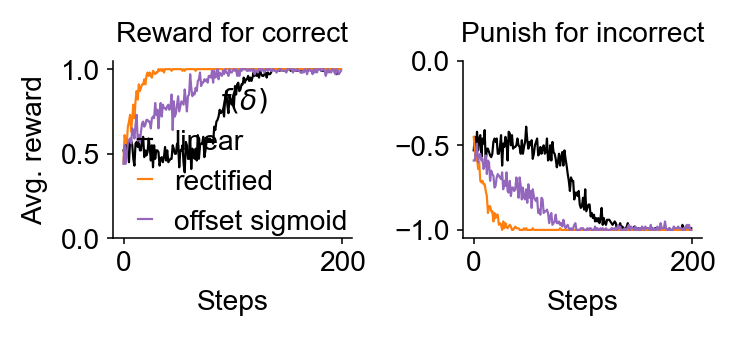

In [9]:
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', fontsize=6)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

cm = 1.0/2.54
plt.rcParams["legend.markerscale"] = 1.0
plt.rcParams['legend.handlelength'] = 0.5
colors = ["black", "tab:orange", "tab:purple"]
kernel = 1
tasks_to_use = [0, 1]
rows = 1
cols = 2

rt = 0
fig, ax = plt.subplots(rows, cols, figsize=(4.25*cm*cols, 4*cm))
#if cols == 1:
#    ax = np.array([ax])


for task_id in tasks_to_use:
    t = tasks_to_use.index(task_id)
    for m in [1, 4, 7]:
        e = 0
        smoothed = [moving_average(r_results[rt, task_id, m, i, :, e], kernel) for i in range(num_trials)]
        ax[t].plot(range(timesteps-kernel+1), np.mean(smoothed, 0), color=colors[m//3], marker="o", markersize=0)#, np.std(smoothed, 0)/np.sqrt(num_trials), color=colors[m%3])

        #for jj in range(10):
        #    ax[task_id, col].plot(range(timesteps-kernel+1), smoothed[jj], color=colors[m%3], alpha=0.5)#,#/np.sqrt(num_trials),


        #print(m, np.mean(smoothed, 0)[-10:])
    #ax[task_id, 0].legend(modes[:3])
    if t == 0:
        ax[t].legend(["linear", "rectified", "offset sigmoid"], title="$f(\delta)$")#, bbox_to_anchor=(1.2, 1.0))
        ax[t].set_ylabel("Avg. reward")
    ax[t].set_xlabel("Steps")
        #if t < len(tasks_to_use)-1:
        #    ax[t].set_xlabel(None)

    if task_id == 0:
        ax[t].set_ylim([0, 1.05])
    if task_id == 1:
        ax[t].set_ylim([-1.05, 0])
    if task_id == 3:
        ax[t].set_ylim([0, 1.05])
    if task_id == 4:
        ax[t].set_ylim([-1.05, 0])

    ax[0].set_title("Reward for correct")
    ax[1].set_title("Punish for incorrect")

    grid = plt.GridSpec(rows, cols)
    #for r in range(rows):
    #    create_subtitle(fig, grid[r, ::], np.array(tasks[r]).squeeze())
    #create_subtitle(fig, grid[0, ::], 'Positive rewards')
    #create_subtitle(fig, grid[1, ::], 'Negative rewards')
    #create_subtitle(fig, grid[2, ::], 'Condition-contingent positive / negative rewards')
    #create_subtitle(fig, grid[3, ::], 'Random rewards')
    print(tasks_to_use)
    #fig.align_ylabels(ax)
fig.tight_layout()
plt.savefig("Fig1_2AFC_overall.pdf")
plt.show()

[0, 1]
[0, 1]


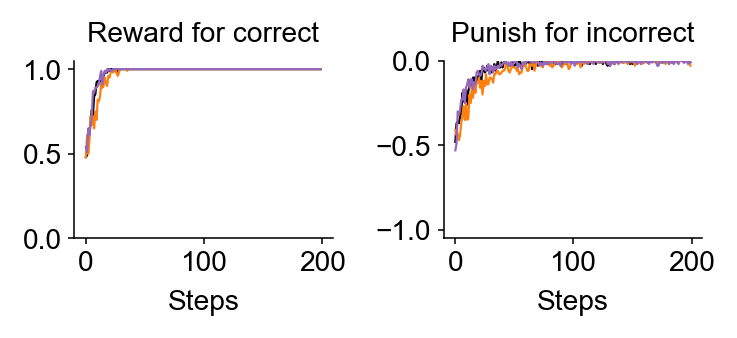

In [8]:
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', fontsize=6)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

cm = 1.0/2.54
plt.rcParams["legend.markerscale"] = 1.0
plt.rcParams['legend.handlelength'] = 0.5
colors = ["black", "tab:orange", "tab:purple"]
kernel = 1
tasks_to_use = [0, 1]
rows = 1
cols = 2

rt = 0
fig, ax = plt.subplots(rows, cols, figsize=(4.25*cm*cols, 4*cm*rows))
#if cols == 1:
#    ax = np.array([ax])


for task_id in tasks_to_use:
    t = tasks_to_use.index(task_id)
    for m in [2, 5, 8]:
        e = 0
        smoothed = [moving_average(r_results[rt, task_id, m, i, :, e], kernel) for i in range(num_trials)]
        ax[t].plot(range(timesteps-kernel+1), np.mean(smoothed, 0), color=colors[m//3], marker="o", markersize=0)#, np.std(smoothed, 0)/np.sqrt(num_trials), color=colors[m%3])

        #for jj in range(10):
        #    ax[task_id, col].plot(range(timesteps-kernel+1), smoothed[jj], color=colors[m%3], alpha=0.5)#,#/np.sqrt(num_trials),


        #print(m, np.mean(smoothed, 0)[-10:])
    #ax[task_id, 0].legend(modes[:3])
    if True:#t == rows-1:
        ax[t].set_xlabel("Steps")
        #ax[t].legend(["linear", "rectified", "offset sigmoid"], title="$f(\delta)$")#, bbox_to_anchor=(1.2, 1.0))
    #ax[t].set_ylabel("Avg. reward")
    
        #if t < len(tasks_to_use)-1:
        #    ax[t].set_xlabel(None)

    if task_id == 0:
        ax[t].set_ylim([0, 1.05])
    if task_id == 1:
        ax[t].set_ylim([-1.05, 0])
    if task_id == 3:
        ax[t].set_ylim([0, 1.05])
    if task_id == 4:
        ax[t].set_ylim([-1.05, 0])

    ax[0].set_title("Reward for correct")
    ax[1].set_title("Punish for incorrect")

    grid = plt.GridSpec(rows, cols)
    #for r in range(rows):
    #    create_subtitle(fig, grid[r, ::], np.array(tasks[r]).squeeze())
    #create_subtitle(fig, grid[0, ::], 'Positive rewards')
    #create_subtitle(fig, grid[1, ::], 'Negative rewards')
    #create_subtitle(fig, grid[2, ::], 'Condition-contingent positive / negative rewards')
    #create_subtitle(fig, grid[3, ::], 'Random rewards')
    print(tasks_to_use)
    #fig.align_ylabels(ax)
fig.tight_layout()
plt.savefig("Fig1_2AFC_overall_efferent.pdf")
plt.show()